In [2]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
import src.ImageEncode as ie
rc('text', usetex=False)
rc('axes', linewidth=3)

In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [4]:
def image_encode(image_values: np.array, npixels: int):
    '''
    Args:
        image_values: 2-dimensional array (non hairy) of image data
    '''
    norm: float = np.linalg.norm(image_values)
    normalized_image_values: np.array = image_values.flatten()/norm
    return normalized_image_values
    

In [5]:
pixelValues = []
for i in range(4):
    value = 0.33 * i
    pixelValues.append(value)
    print(value)


0.0
0.33
0.66
0.99


[[0.   0.33]
 [0.66 0.99]]


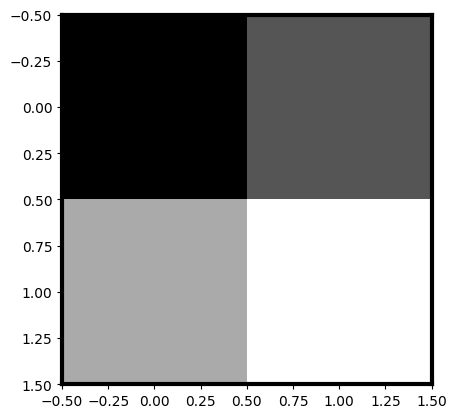

[0.         0.26726124 0.53452248 0.80178373]


In [6]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
print(values)
normalized = ie.normalize(values)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
print(normalized)

In [7]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = np.random.randn(n_train,n)+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states
    

In [8]:
a = generate_training(normalized, 100, 2)
print(a)
for i in a:
    print(np.linalg.norm(i))

(100, 4)
(4,)
[[ 2.04543051e-01+0.j -1.80815269e-01+0.j -6.20780375e-01+0.j
  -7.34914760e-01+0.j]
 [-3.15818491e-01+0.j  2.28187356e-01+0.j  8.46549592e-01+0.j
  -3.62688571e-01+0.j]
 [-2.39716674e-01+0.j -8.16197019e-03+0.j  7.56994361e-01+0.j
   6.07806577e-01+0.j]
 [ 9.13570309e-01+0.j  3.86007055e-01+0.j  2.95149849e-02+0.j
   1.24566083e-01+0.j]
 [-4.28905815e-01+0.j -4.50670535e-01+0.j  4.72613020e-01+0.j
  -6.24157676e-01+0.j]
 [ 3.77093394e-01+0.j -8.36091296e-01+0.j  7.06478729e-02+0.j
  -3.92123444e-01+0.j]
 [-4.07752528e-01+0.j -6.96920436e-01+0.j -9.02186049e-04+0.j
   5.89948275e-01+0.j]
 [ 7.63116866e-01+0.j -1.42132320e-01+0.j  6.00591829e-01+0.j
  -1.91678137e-01+0.j]
 [ 1.69959099e-01+0.j  3.54638156e-01+0.j -9.12853935e-01+0.j
  -1.09742322e-01+0.j]
 [-5.74739008e-01+0.j  7.86301294e-02+0.j  1.77917603e-01+0.j
  -7.94882194e-01+0.j]
 [-2.46541625e-01+0.j -7.90741933e-01+0.j  7.35090651e-02+0.j
   5.55464526e-01+0.j]
 [-6.19567212e-01+0.j  4.08300285e-01+0.j -6.257233

In [39]:
#generate diffusion data
n = 2
T = 20
Ndata = 400

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(generate_training(normalized, Ndata, 2))

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

(400, 4)
(4,)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [10]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [12]:
#train on diffusion data
n, na = 2, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 400 # number of data in the training data set
epochs = 2001 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = Xout

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        print(tt)
        params_tot[tt] = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%tt)
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)
    params = params.detach().numpy()
    loss_hist = loss_hist.detach().numpy()
    np.save('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t, params)
    np.save('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t, loss_hist)
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(0.1064, grad_fn=<SubBackward0>), time elapsed: 0.06264543533325195 seconds
Step 100, loss: tensor(0.0725, grad_fn=<SubBackward0>), time elapsed: 6.182528734207153 seconds
Step 200, loss: tensor(0.0586, grad_fn=<SubBackward0>), time elapsed: 12.631946325302124 seconds
Step 300, loss: tensor(0.0418, grad_fn=<SubBackward0>), time elapsed: 19.06618905067444 seconds
Step 400, loss: tensor(0.0296, grad_fn=<SubBackward0>), time elapsed: 26.45806097984314 seconds
Step 500, loss: tensor(0.0171, grad_fn=<SubBackward0>), time elapsed: 33.10645914077759 seconds
Step 600, loss: tensor(0.0199, grad_fn=<SubBackward0>), time elapsed: 39.55510330200195 seconds
Step 700, loss: tensor(0.0100, grad_fn=<SubBackward0>), time elapsed: 46.13269257545471 seconds
Step 800, loss: tensor(0.0119, grad_fn=<SubBackward0>), time elapsed: 52.43871736526489 seconds
Step 900, loss: tensor(0.0121, grad_fn=<SubBackward0>), time elapsed: 59.36052703857422 seconds
Step 1000, loss: tensor(0.0034, grad_fn

In [ ]:
n, na = 2, 1
T = 20
L = 6
Ndata = 100
epochs = 2001

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t)
    loss_tot[t] = np.load('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t)

np.save('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_mmd.npy', params_tot)
np.save('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_mmd.npy', loss_tot)

#Define inputs here
#Training input
#Testing input
values = np.array([pixelValues[0:2], pixelValues[2:4]])
normalized = ie.normalize(values)
normalized = normalized.ravel() + 0j*np.zeros(4)

inputs_T_tr = []

model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
data_te = model.backDataGeneration(normalized, params_tot, Ndata)[:, :, :2**n].numpy()

np.save('data/cluster/n2/QDDPMcluster0trainGen_n2na1T20L6_mmd.npy', data_tr)
np.save('data/cluster/n2/QDDPMcluster0testGen_n2na1T20L6_mmd.npy', data_te)

[0.02723781 0.02737894 0.02737894 ... 0.02822571 0.02780233 0.02794345]
[[0.02723781 0.02737894 0.02737894 0.02752007]
 [0.0276612  0.0276612  0.02780233 0.02780233]
 [0.02780233 0.02780233 0.02794345 0.0276612 ]
 ...
 [0.02328621 0.02526201 0.02737894 0.02808458]
 [0.02610878 0.02624991 0.02709668 0.02794345]
 [0.02822571 0.02822571 0.02780233 0.02794345]]


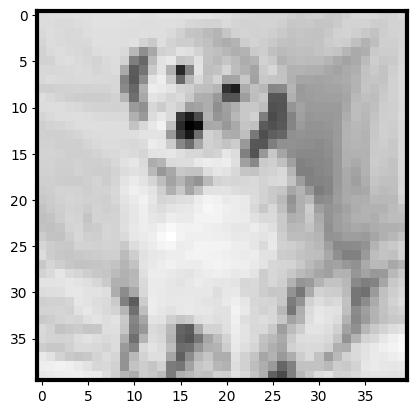

In [42]:
from PIL import Image
scale = 40
img = Image.open('dog.jpg')
img_greyscale = img.convert("L")
img_resized = img_greyscale.resize((scale, scale))
img_array = np.array(img_resized, ndmin = 2)
img_resized.save('dog_resized_greyscale.jpg')
img_final_array = np.zeros((scale, scale), dtype = object)


normalized_img_array = ie.normalize(img_array)
normalized_img_array = normalized_img_array.ravel() + 0*j*np.zeros(scale*scale)
test_data = np.zeros((int(normalized_img_array.size / 4), 4))
for i in range(0, normalized_img_array.size):
    test_data[int(i / 4)][i % 4] = normalized_img_array[i]

print(normalized_img_array)
print(test_data)

plt.imshow(img_array, cmap='grey',interpolation = 'nearest')

[[0.   0.33]
 [0.66 0.99]]


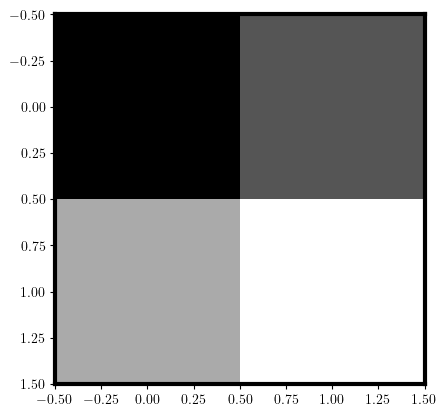

[0.        +0.j 0.26726124+0.j 0.53452248+0.j 0.80178373+0.j]


In [20]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
print(values)
normalized = ie.normalize(values)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
normalized = normalized.ravel() + 0j*np.zeros(4)
print(normalized)
